In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


import pickle
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score

[[ 0.2782208   0.20921635 -0.15783327 -0.11597944  0.50267757]
 [ 0.20921635  0.62540461 -0.07440552 -0.1590074  -0.34949867]
 [-0.15783327 -0.07440552  0.56790749 -0.23986521 -0.04603175]
 [-0.11597944 -0.1590074  -0.23986521  0.53484125  0.11551827]
 [ 0.50267757 -0.34949867 -0.04603175  0.11551827 -0.10637415]]
(5,) (5, 5)


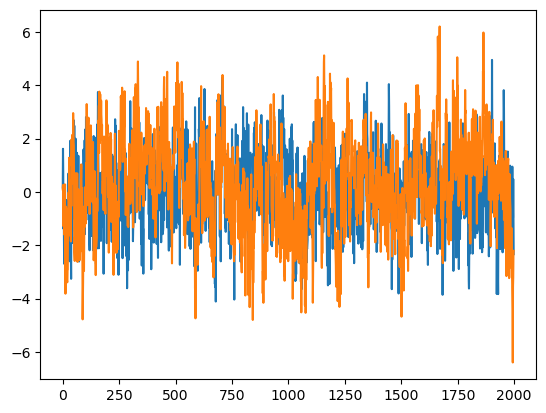

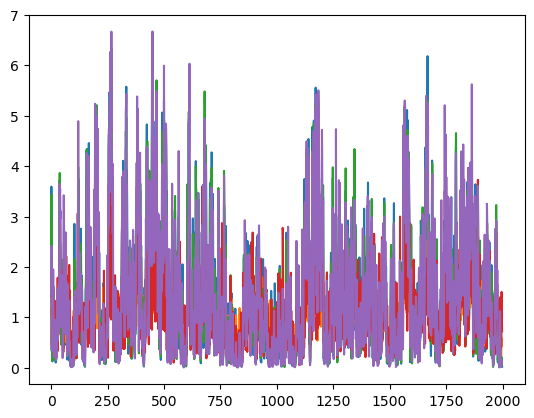

1.2604857279355934


In [18]:
# Simulate some data
torch.manual_seed(0)
np.random.seed(0)
N = 100
x_dim = 5

# sqrt m  division in matrix C 

# A = np.array([[0.9, 0.4], [-0.2, 0.8]])
# s = np.array([0.8, 0.99]).reshape(1, -1)
# u, _ = np.linalg.qr(np.random.randn(s.shape[1], s.shape[1]))
# A = u @ np.diag(s.squeeze()) @ u.T
eigs = np.array([-0.6, 0.2, 0.6, 0.8, 0.9])
A = np.diag(eigs)
u, _ = np.linalg.qr(np.random.randn(x_dim, x_dim))
A = u @ A @ u.T
print(A)

# B = np.array([[0.1, 0.0], [0.0, 0.1]])
B = 1 * np.eye(x_dim)
# W = np.eye(x_dim)
W = np.random.randn(x_dim, x_dim) / np.sqrt(x_dim)



# Have C to be multiple identity matrices
# C = np.vstack([np.eye(x_dim)] * (N//x_dim)) # Could also use random weights with std sqrt(m)
C = np.random.randn(N, x_dim) / np.sqrt(x_dim)

sigma_x = 0.01

# mu0 = np.array([0., 0.])
# Sigma0 = np.array([[.010, 0.0], [0.0, .010]])
mu0 = np.zeros(x_dim)
Sigma0 = 1 * np.eye(x_dim)
print(mu0.shape, Sigma0.shape)

ntrials = 1
# v0 = np.random.multivariate_normal(mu0, Sigma0)
v0 = mu0 + (np.linalg.cholesky(Sigma0) @ np.random.randn(ntrials,x_dim, 1)).squeeze(-1)

T = 2000
v = np.zeros((ntrials,x_dim,T))
x = np.zeros((ntrials,x_dim,T))
x_noise_free = np.zeros((ntrials,x_dim,T))
v[:,:, 0] = v0
x_noise_free[:,:, 0] = (W @ v0[..., None]).squeeze(-1)
x[:,:, 0] = (W @ v0[..., None]).squeeze(-1) + sigma_x * np.random.randn(ntrials, x_dim,)
for t in range(1, T):
    v[..., t] = (A @ v[..., t-1][..., None]).squeeze(-1) + (B @ np.random.randn(ntrials, x_dim,1)).squeeze(-1)
    x_noise_free[..., t] = (W @ v[..., t][..., None]).squeeze(-1)
    x[..., t] = (W @ v[..., t][..., None]).squeeze(-1) + sigma_x * np.random.randn(ntrials, x_dim)

stop = -1
plt.plot(v[-1,0,:stop])
plt.plot(v[-1,1,:stop])
plt.show()

_d = 0.5
F = C[None, ...] @ x + _d
# plt.plot(F[0,0,:stop])
# plt.plot(F[0,1,:stop])

# link = np.exp
link = lambda x: 1 * np.log(1 + np.exp(x))
dt = 1
for i in range(5):
    plt.plot(link(F[0,i,:stop])*dt)
plt.show()

# Average firing rate
print(np.mean(link(F)))


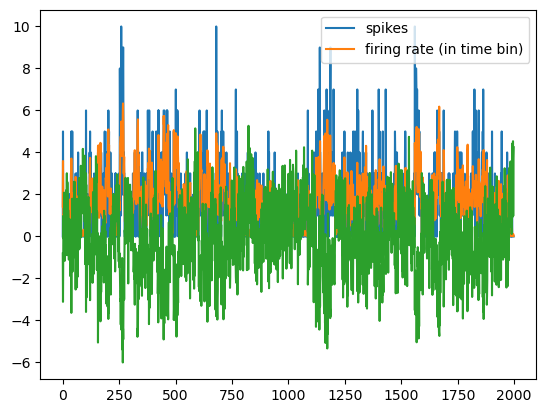

In [19]:
# link_fn = torch.exp
# link = lambda x: np.exp(x)
link_fn = lambda x: 1 * torch.nn.functional.softplus(x)
link = lambda x: 1 * np.log(1 + np.exp(x))
lik = Poisson_noise()
Y = np.random.poisson(link(F)*dt)

train_len = 1000
Y_train = Y[..., :train_len]
v_train = v[..., :train_len]
Y_test = Y[..., train_len:]
v_test = v[..., train_len:]


# sigma = 0.1
# Y = np.random.randn(*F.shape) * sigma + F
# lik = Gaussian_noise(sigma)
# link_fn = lambda x: x

# # Sigmoid link function
# link = lambda x: 1 / (1 + np.exp(-x))
# Y = np.random.negative_binomial(link(F), 0.5)
# lik = Negative_binomial_noise(Tensor(Y))
# link_fn = lambda x:x

plt.plot(Y[0,0,:stop], label='spikes')
# plt.plot(Y[0,1,:stop])
plt.plot(link(F[0,0,:stop])*dt, label='firing rate (in time bin)')
plt.plot(x_noise_free[0,0,:stop])
plt.legend()
plt.show()

_W = torch.tensor(np.random.randn(1,x_dim, x_dim) / np.sqrt(x_dim)).float().to(device)
_C = torch.tensor(np.random.randn(1,N, x_dim) / np.sqrt(x_dim)).float().to(device)

# model = LDS(Tensor(v_train), Tensor(Y_train), lik, x_dim=x_dim, link_fn=link_fn, fixed_d=False, d=_d, W=_W, C=_C)
# train_params = {'batch_size': None, 'n_mc': 500, 'step_size': 100, 'lrate': 1e-2, 'max_steps': 1001, 'gamma': 0.85, 'StepLR': True}
# np.random.seed(0)
# torch.manual_seed(0)
# model.train_supervised_model(model.training_params(**train_params))
# model.plot_LL()

# Fixed generative model
model = LDS(Tensor(v_train), Tensor(Y_train), lik, x_dim=x_dim, link_fn=link_fn, 
            A=Tensor(A[None, ...]).to(device), B=Tensor(B[None, ...]).to(device), W=Tensor(W[None,...]).to(device), C=Tensor(C[None, ...]).to(device),
            mu0=Tensor(mu0[None, ...]).to(device), Sigma0_half=Tensor(np.linalg.cholesky(Sigma0)[None, ...]).to(device),
            sigma_x=(torch.ones(x_dim) * sigma_x).to(device), d=_d)

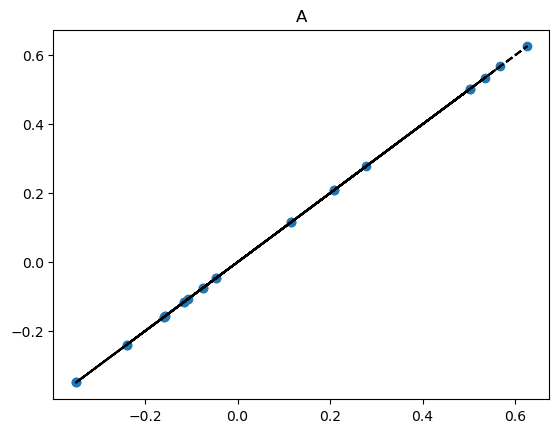

0.5 0.5


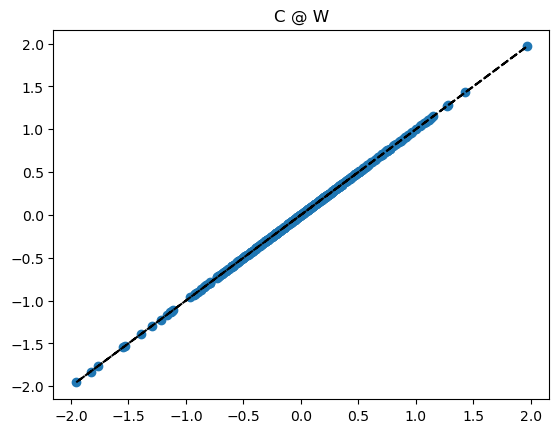

[[[ 1.  0.  0.  0.  0.]
  [ 0.  1.  0.  0.  0.]
  [ 0.  0.  1.  0.  0.]
  [ 0.  0.  0.  1.  0.]
  [ 0.  0.  0. -0.  1.]]] [[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0. -0.  1.]]
tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100], device='cuda:0',
       grad_fn=<ExpBackward0>) 0.01
[[0. 0. 0. 0. 0.]] [0. 0. 0. 0. 0.]
Parameter containing:
tensor([[[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.]]], device='cuda:0', requires_grad=True) [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [20]:
# for name, prm in model.named_parameters():
#     if name in ['C', 'W']:
#         continue
#     print(f'Name: {name} - Shape: {prm.shape} - Parameter: {prm}')


# # print(C @ W )
# # print(model.C @ model.W)
# print((C@W - (model.C @ model.W).detach().cpu().numpy()))
# # print(C @ W)
# print(model.Sigma0)

plt.plot(model.A.detach().cpu().numpy().flatten(), A.flatten(), 'o')
# plot y = x line 
plt.plot(A.flatten(), A.flatten(), 'k--')
plt.title('A')
plt.show()

print(model.d.detach().cpu().numpy(), _d)

plt.plot((model.C @ model.W).detach().cpu().numpy().flatten(), (C @ W).flatten(), 'o')
# plot y = x line
plt.plot((C @ W).flatten(), (C @ W).flatten(), 'k--')
plt.title('C @ W')
plt.show()

print(model.Sigma0_half.detach().cpu().numpy(), np.linalg.cholesky(Sigma0))

print(model.sigma_x, sigma_x)

print(model.mu0.detach().cpu().numpy(), mu0)

print(model.B, B)


torch.Size([1, 1, 5, 1000])


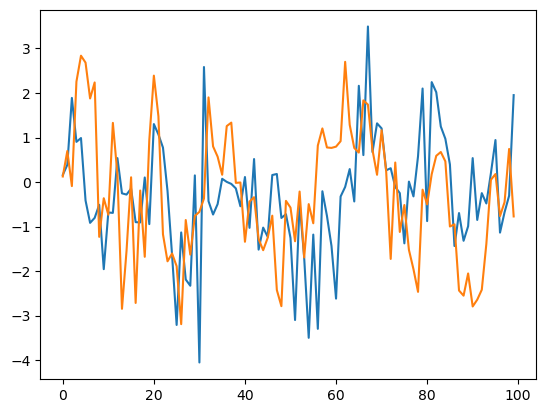

In [5]:
model.freeze_params()
z_samps = model.sample_z(1, trials=1)
print(z_samps.shape)
stop = 100
for i in range(len(z_samps)):
    plt.plot(z_samps[i,0,0, :stop].detach().cpu().numpy())
    plt.plot(z_samps[i,0,1, :stop].detach().cpu().numpy())
    plt.show()

In [6]:
# Load saved neural network
state_dict = torch.load('my_sequential_model.pth')

5
step 0 LL -1.65184140625 Entropy -0.0460018359375 Joint LL -1.60583953125
step 1 LL -1.59679921875 Entropy -0.0460018359375 Joint LL -1.55079734375
step 2 LL -1.5548384375 Entropy -0.0460018359375 Joint LL -1.5088365625
step 3 LL -1.5225778125 Entropy -0.0460018359375 Joint LL -1.4765759375
step 4 LL -1.509111953125 Entropy -0.0460018359375 Joint LL -1.463110078125
step 5 LL -1.50012 Entropy -0.0460018359375 Joint LL -1.454118125
step 6 LL -1.490629296875 Entropy -0.0460018359375 Joint LL -1.444627421875
step 7 LL -1.488186953125 Entropy -0.0460018359375 Joint LL -1.442185078125
step 8 LL -1.48985265625 Entropy -0.0460018359375 Joint LL -1.44385078125
step 9 LL -1.48643046875 Entropy -0.0460018359375 Joint LL -1.44042859375
step 10 LL -1.47890890625 Entropy -0.0460018359375 Joint LL -1.43290703125
step 11 LL -1.47467375 Entropy -0.0460018359375 Joint LL -1.428671875
step 12 LL -1.4695540625 Entropy -0.0460018359375 Joint LL -1.4235521875
step 13 LL -1.468010625 Entropy -0.04600183593

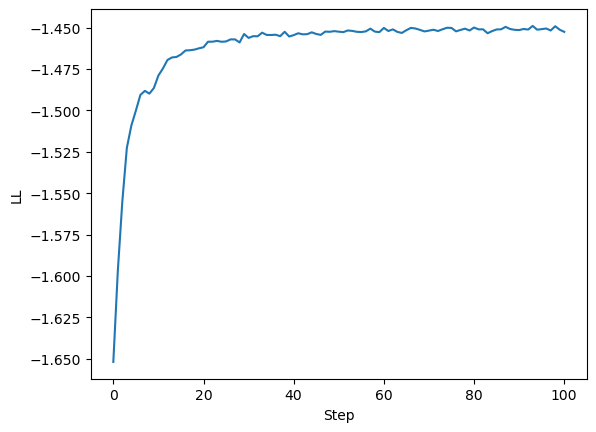

In [10]:

model.freeze_params()
print(model.x_dim)

# class MyRNNModel(Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(MyRNNModel, self).__init__()
#         self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True, num_layers=2)
#         self.fc = torch.nn.Linear(hidden_size * 2, output_size)

#     def forward(self, x):
#         out, _ = self.rnn(x)
#         out = self.fc(out)
#         return out

# neural_net = MyRNNModel(model.N, 100, model.x_dim)

# # # Substituting the true parameters
# # neural_net = torch.nn.Sequential(
# #                 torch.nn.Linear(model.N, 100),
# #                 torch.nn.ReLU(),
# #                 torch.nn.Linear(100, 100),
# #                 torch.nn.ReLU(),
# #                 torch.nn.Linear(100, 100),
# #                 torch.nn.ReLU(),
# #                 # torch.nn.Linear(100, 100),
# #                 # torch.nn.ReLU(),
# #                 torch.nn.Linear(100, model.x_dim)
# #             )
# # # neural_net.load_state_dict(state_dict)
# # # rec_model = RecognitionModel(model, neural_net=neural_net)

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True) # needs ntrials, T, N
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

neural_net = RNNModel(model.N, 100, model.x_dim)
# neural_net.load_state_dict(state_dict)

rec_model = RecognitionModel(model, rnn=False)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 5e-3, 'max_steps': 101, 'n_mc_x': 50, 'n_mc_z': 50, 'batch_mc_z': 25}
rec_model.train_recognition_model(rec_model.training_params(**train_params))
rec_model.plot_LL()

torch.Size([1, 100, 1000])


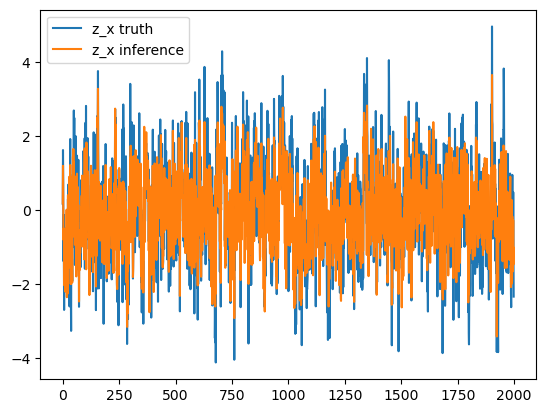

0.7028639226529695 z_0
0.8846757570846505 z_1
0.887480807231388 z_2
0.9277372993666033 z_3
0.7457778056853626 z_4
(1, 5, 2000)


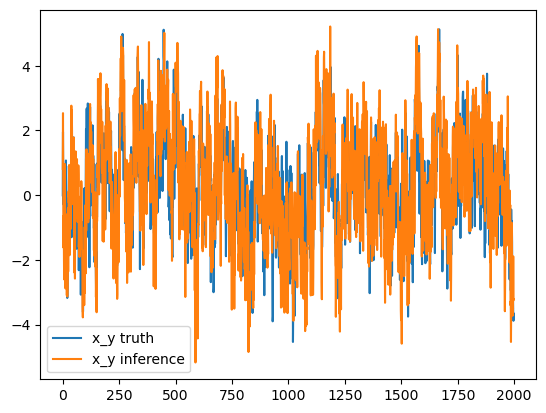

-2.6247769200224162 x_0
0.10976088195036338 x_1
-1.930734796147104 x_2
-2.0017999221506 x_3
-4.648523587732076 x_4
(1, 5, 1000)


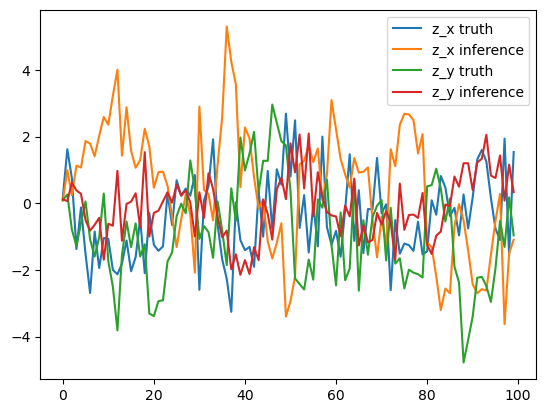

ValueError: Found input variables with inconsistent numbers of samples: [2000, 1000]

In [16]:
print(rec_model.gen_model.Y.shape)
z = rec_model.test_z(Tensor(Y).to(device))
z = z.detach().cpu().numpy()

start = 0
stop = -1
plt.plot(v[0,0,start:stop], label = 'z_x truth')
# plt.plot(v[0,1,:100], label = 'z_y truth')
plt.plot(z[0,0,start:stop], label = 'z_x inference')
# plt.plot(z[0,1,:100], label = 'z_y inference')
plt.legend()
plt.show()

# for i in range(5):
#     plt.plot(z[0,i,:stop], label = 'z_x inference')
# plt.show()
# for i in range(5):
#     plt.plot(v[0,i,:stop], label = 'z_x truth')   
#     # plt.legend()
# plt.show()

# print R^2 for x and y decoding using sklearn
# print(r2_score(v[0,1,:], z[0,1,:]))
# print(r2_score(v[0,0,:], z[0,0,:]))
for i in range(rec_model.gen_model.b):
    print(r2_score(v[0,i,:], z[0,i,:]), 'z_{}'.format(i))

x_tilde = rec_model.get_x_tilde(Tensor(Y).to(device)).detach().cpu().numpy()
print(x_tilde.shape)
stop = -1
# plt.plot(x_noise_free[0,0,:stop], label = 'x_x truth')
# plt.plot(x_tilde[0,0,:stop], label = 'x_x inference')
plt.plot(x_noise_free[0,1,:stop], label = 'x_y truth')
plt.plot(x_tilde[0,1,:stop], label = 'x_y inference')
plt.legend()
plt.show()
# print R^2 for x_tilde
for i in range(rec_model.gen_model.x_dim):
    print(r2_score(x_noise_free[0,i,:], x_tilde[0,i,:]), 'x_{}'.format(i))
# print(r2_score(x_noise_free[0,0,:], x_tilde[0,0,:]), 'x_x')
# print(r2_score(x_noise_free[0,1,:], x_tilde[0,1,:]), 'x_y')
# print(r2_score(x_noise_free, x_tilde), 'x_all')

# _, _, Ks, Cs = rec_model.kalman_covariance() # TODO: should I use prev_mu and prev_Sigma?
# _ , mus_smooth, _ = rec_model.kalman_means(Tensor(x_noise_free[None, ..., :train_len]).to(device), Ks, Cs) # (T_test, 1, ntrials, b)
# # _ , mus_smooth, _ = rec_model.kalman_means(Tensor(x[None, ...]).to(device), Ks, Cs) # (T_test, 1, ntrials, b)
# mus_smooth = mus_smooth.detach().cpu().numpy().squeeze(1).transpose(1, 2, 0)
# print(mus_smooth.shape)
# stop = 100
# plt.plot(v[0,0,:stop], label = 'z_x truth')
# plt.plot(mus_smooth[0, 0,:stop], label = 'z_x inference')
# plt.plot(v[0,1,:stop], label = 'z_y truth')
# plt.plot(mus_smooth[0, 1,:stop], label = 'z_y inference')
# plt.legend()
# plt.show()

# # print R^2 for x and y smoothing using sklearn
# print(r2_score(v[0,1,:], mus_smooth[0, 1,:]))
# print(r2_score(v[0,0,:], mus_smooth[0, 0,:]))


In [ ]:
# Checking what sampled posteriors look like
matheron_pert = rec_model.sample_matheron_pert(100)
print(matheron_pert.shape)
x_hat = Tensor(x[None, ...]).to(device) - matheron_pert[..., :x_tilde.shape[-1]]
print(x_hat.shape)
_, _, Ks, Cs = rec_model.kalman_covariance() # TODO: should I use prev_mu and prev_Sigma?
_ , _mus_smooth, _ = rec_model.kalman_means(x_hat, Ks, Cs) # (batch_size, n_mc_z, ntrials, b)
_mus_smooth = _mus_smooth.permute(1,2,3,0).squeeze().detach().cpu().numpy()
print(_mus_smooth.shape)


# # Find the prior mean
# z_samps = model.sample_z(10000)
# z_samps = z_samps.squeeze().detach().cpu().numpy()
# print(z_samps.shape)

In [ ]:
# stop = 100
# for i in range(len(_mus_smooth)):
#     plt.plot(_mus_smooth[i,0,:stop])
#     # plt.plot(_mus_smooth[i,0,1,:stop])
#     # plt.show()
# plt.show()

stop = -1
posterior_avg = _mus_smooth.mean(0)
prior_avg = z_samps.mean(0)
plt.plot(posterior_avg[0,:stop], label = 'posterior avg')
plt.plot(mus_smooth[0,:stop], label = 'smoothing')
# plt.plot(prior_avg[0,:stop], label = 'prior avg')
# plt.plot(z_samps[0,0,:stop], label = 'prior sample')
plt.legend()
plt.show()
# print R^2 between posterior mean and smoothing
print(r2_score(mus_smooth[0,:], posterior_avg[0,:]))
print(r2_score(mus_smooth[1,:], posterior_avg[1,:]))